In [10]:
import cv2
import numpy as np
from darkflow.net.build import TFNet
import matplotlib.pyplot as plt
import imutils
from imutils import contours

(1080, 1920, 3)

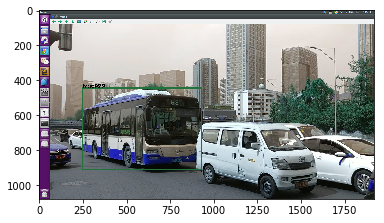

In [11]:
img = cv2.imread('/home/leij/Pictures/bus-test.png')
plt.imshow(img)
img.shape

In [12]:
newImg = imutils.resize(img,width=600)
newImg.shape[1] / float(1900
                    )

0.3157894736842105

In [13]:
options = {
    'model': 'cfg/yolo.cfg',
    'load': 'bin/yolov2.weights',
    'threshold': 0.6,
    'gpu': 0.8
}
tfnet = TFNet(options)
# img = cv2.imread('/home/leij/obj-detection/darkflow-master/bus/bus-photos/IMG_20180421_155655.jpg', cv2.IMREAD_COLOR)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
results = tfnet.return_predict(img)

/home/leij/obj-detection/darkflow-master/darkflow/dark/darknet.py:54: UserWarning: ./cfg/yolov2.cfg not found, use cfg/yolo.cfg instead
  cfg_path, FLAGS.model))


Parsing cfg/yolo.cfg
Loading bin/yolov2.weights ...
Successfully identified 203934260 bytes
Finished in 0.029379844665527344s
Model has a coco model name, loading coco labels.

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 608, 608, 3)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 608, 608, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 304, 304, 32)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 304, 304, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 152, 152, 64)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load  |  Yep!  | conv 1x1p0_1  +bnorm  leaky      | (?, 152, 152, 64)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 76, 76, 128)
 Load  |  Yep!  | conv 3x3p1_1  +b

In [14]:
for i in results:
    if i['label'] == 'bus':
        result = i
        break
result

{'bottomright': {'x': 917, 'y': 902},
 'confidence': 0.9398584,
 'label': 'bus',
 'topleft': {'x': 271, 'y': 450}}

In [15]:
tl = (result['topleft']['x'], result['topleft']['y'])
br = (result['bottomright']['x'], result['bottomright']['y'])
label = result['label']
confidence = result['confidence']

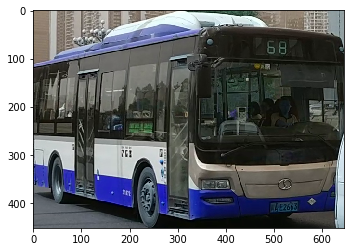

In [16]:
busROI = img[tl[1]:br[1],tl[0]:br[0]]
plt.imshow(busROI)

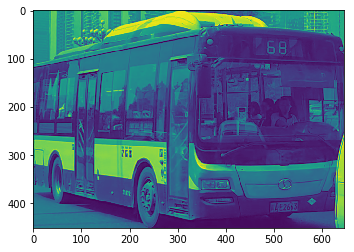

In [17]:
gray = cv2.cvtColor(busROI,cv2.COLOR_RGB2GRAY)
plt.imshow(gray)

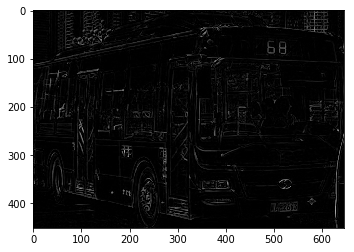

In [18]:
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3))
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
tophat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, sqKernel)
plt.imshow(cv2.cvtColor(tophat,cv2.COLOR_GRAY2BGR))

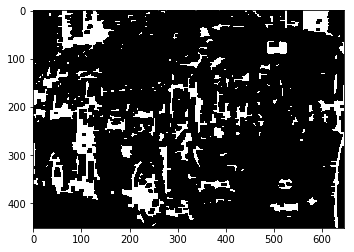

In [19]:
gradX = cv2.Sobel(tophat, ddepth=cv2.CV_32F, dx=1, dy=0,ksize=-1)
gradX = np.absolute(gradX)
(minVal, maxVal) = (np.min(gradX), np.max(gradX))
gradX = (255 * ((gradX - minVal) / (maxVal - minVal)))
gradX = gradX.astype("uint8")

# apply a closing operation using the rectangular kernel to help
# cloes gaps in between credit card number digits, then apply
# Otsu's thresholding method to binarize the image
gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel)
thresh = cv2.threshold(gradX, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

# apply a second closing operation to the binary image, again
# to help close gaps between credit card number regions
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)
plt.imshow(cv2.cvtColor(thresh,cv2.COLOR_GRAY2BGR))

In [20]:
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if imutils.is_cv2() else cnts[1]

In [22]:
len(cnts)

255

In [12]:
locs = []
for (i,c) in enumerate(cnts):
    (x,y,w,h) = cv2.boundingRect(c)
    ar = w/float(h)
    if ar > 1 and ar < 3.0:
        if (x > 400 and x < 600) and (y > 0 and y < 100):
            if (w > 10 and w < 60) and (h > 20 and h < 30):
                locs.append((x, y, w, h))
                print(x,y,w,h)
        

486 64 41 28


In [13]:
locs = sorted(locs, key=lambda x:x[0])
locs

[(486, 64, 41, 28)]

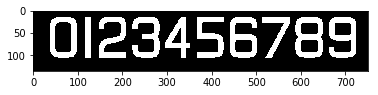

In [14]:
ref = cv2.imread('/home/leij/Pictures/number.png')
ref = cv2.cvtColor(ref, cv2.COLOR_BGR2GRAY)
ref = cv2.threshold(ref, 10, 255, cv2.THRESH_BINARY_INV)[1]

plt.imshow(cv2.cvtColor(ref,cv2.COLOR_GRAY2RGB))

In [34]:
refCnts = cv2.findContours(ref.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
refCnts = refCnts[0] if imutils.is_cv2() else refCnts[1]
refCnts = contours.sort_contours(refCnts, method="left-to-right")[0]
digits = {}
# loop over the OCR-A reference contours
for (i, c) in enumerate(refCnts):
# compute the bounding box for the digit, extract it, and resize
# it to a fixed size
    (x, y, w, h) = cv2.boundingRect(c)
    print(i,x,y,w,h)
    roi = ref[y-2:y + h+2, x-2:x + w+2]
    roi = cv2.resize(roi, (57, 88))
    # update the digits dictionary, mapping the digit name to the ROI
    digits[i] = roi

0 38 15 60 91
1 117 15 12 91
2 148 15 61 91
3 223 15 61 91
4 296 15 55 91
5 367 15 61 91
6 441 15 62 91
7 514 16 63 90
8 588 15 63 91
9 663 15 61 91


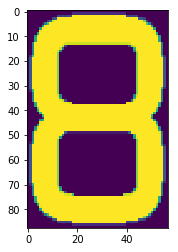

In [40]:
plt.imshow(digits[8])

0 486 64 41 28
[32686966.0, -5529179.5, 17149660.0, 30269208.0, -4518453.0, 40557368.0, 47585484.0, -8327829.5, 43166664.0, 37600572.0]
[40540264.0, -15437140.0, 25624232.0, 37276124.0, -11157434.0, 29158816.0, 44271540.0, -9139163.0, 48200020.0, 45249480.0]
['6', '8']


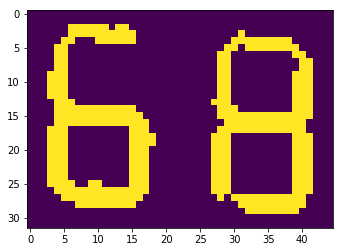

In [44]:
output = []
groupOutput = []
for (i,(x,y,w,h)) in enumerate(locs):
    print(i,x,y,w,h)
    group = gray[y-2:y+h+2,x-2:x+w+2]
    group = cv2.threshold(group, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    plt.imshow(group)
    digitCnts = cv2.findContours(group.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    digitCnts = digitCnts[0] if imutils.is_cv2() else digitCnts[1]
    digitCnts = contours.sort_contours(digitCnts,method="left-to-right")[0]
    
    for c in digitCnts:
        (gX,gY,gW,gH) = cv2.boundingRect(c)
        roi = group[gY:gY+gH,gX:gX+gW]
        
        roi = cv2.resize(roi,(57,88))
        
#         plt.imshow(roi)
        scores = []
        
        for (digit,digitROI) in digits.items():
            result = cv2.matchTemplate(roi,digitROI,cv2.TM_CCOEFF)
            
            (_, score, _, _) = cv2.minMaxLoc(result)
            scores.append(score)
        print(scores)
        groupOutput.append(str(np.argmax(scores)))
    print(groupOutput)
cv2.rectangle(busROI, (x - 5, y - 5),(x + w + 5, y + h + 5), (0, 0, 255), 2)
cv2.putText(busROI, "".join(groupOutput), (x, y - 15),
cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 0, 255), 2)

print("Bus Number is #: {}".format("".join(output)))
cv2.imshow("busROI", busROI)
cv2.waitKey(0)

In [ ]:
plt.imshow(gray)